1. Analiza wstępna

Po wstępnym przejrzeniu dostarczonych obrazków można dojść do wniosku, że otrzymany dataset jest raczej trudny z następujących powodów:

- Część zdjęć jest mocno rozmazana
- Są też inne czynniki sprawiające, że część zdjęć jest słabej jakości, np. w train/0000662/442 zrobione jest zdjęcie monitora, na której wyświetla się targetowana osoba.
- Ta sama osoba na różnych zdjęciach może mieć zupełnie różne fryzury i kolory włosów. Dla części osób w folderze znajdują się zarówno zdjęcia z dzieciństwa i młodości oraz zdjęcia z późniejszych lat (kiedy wyglądali już zupełnie inaczej) 
- Na części zdjęć poza szukanymi osobami znajdują się też inni ludzie (czasem nawet na pierwszym planie, podczas gdy nasz target jest gdzieś w tle)
- Czasami ciężko stwierdzić, czy w ogóle zdjęcie przedstawia tę osobę, co trzeba (np. w train/0000439/239), a czasami wręcz oczywiste jest, że zdjęcie przedstawia nie tę osobę, co trzeba (np. w train/0000439/260 albo w train/0000662/334, gdzie zamiast mężczyzny na zdjęciu jest kobieta)
- Twarze na zdjęciach pojawiają się pod przeróżnymi kątami. Dość mocno zmienia się też kolorystyka i jasność obrazów (np. w train/0000662/330)
- Jako, że są to aktorzy, to spora część zdjęć przedstawia ich wcielonych w pewne role filmowe, gdzie potrzafią zupełnie inaczej wyglądać ze względu na kostiumy, peruki, okulary przeciwsłoneczne, zarost, kolczyki, makijaż, sztuczną krew, maskę mima, opaski, kaski itd.
- część osób wygląda dość podobnie (przynajmniej ja miałbym problem z rozróżnieniem niektórych z nich, bo raczej nie kojarzę tych twarzy), co w połączeniu z tym, że każda z tych osób na różnych zdjęciach może wyglądać zupełnie inaczej sprawia, że łatwo je mylić.
- 28 klas to dość sporawo

Reasumując, wydaje mi się, że przy takim zadaniu sam miałbym spory problem z osiągnięciem dobrej skuteczności w dopasowywaniu. Przed rozpoczęciem pracy miałem wrażenie, że 75% ustalone jako dolna granica skuteczności będzie już dobrym i niełatwym do osiągnięcia wynikiem.

Ściągnięcie i rozpakowanie danych:

In [ ]:
!wget https://www.mimuw.edu.pl/~ciebie/dnn2020-1.zip
!unzip dnn2020-1.zip

Streaming output truncated to the last 5000 lines.
  inflating: dnn2020-1/train/0010075/435.jpg  
  inflating: dnn2020-1/train/0010075/489.jpg  
  inflating: dnn2020-1/train/0010075/219.jpg  
  inflating: dnn2020-1/train/0010075/442.jpg  
  inflating: dnn2020-1/train/0010075/345.jpg  
  inflating: dnn2020-1/train/0010075/410.jpg  
  inflating: dnn2020-1/train/0010075/306.jpg  
  inflating: dnn2020-1/train/0010075/393.jpg  
  inflating: dnn2020-1/train/0010075/192.jpg  
  inflating: dnn2020-1/train/0010075/453.jpg  
  inflating: dnn2020-1/train/0010075/353.jpg  
  inflating: dnn2020-1/train/0010075/227.jpg  
  inflating: dnn2020-1/train/0010075/275.jpg  
  inflating: dnn2020-1/train/0010075/144.jpg  
  inflating: dnn2020-1/train/0010075/125.jpg  
  inflating: dnn2020-1/train/0010075/140.jpg  
  inflating: dnn2020-1/train/0010075/162.jpg  
  inflating: dnn2020-1/train/0010075/300.jpg  
  inflating: dnn2020-1/train/0010075/325.jpg  
  inflating: dnn2020-1/train/0010075/229.jpg  
  inflati

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import pandas as pd
from IPython.display import Image, display

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Preprocessing danych tak, aby dało się je potem użyć w sieci neuronowej. Wzorowałem się tu na przesłanym w materiałach tutorialu pytorcha. Wydzieliłem też ze zbioru treningowego zbiór walidacyjny wielkości 2000.

In [ ]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [ ]:
def get_data(batch_size):
  transform = transforms.Compose(
    [transforms.ToTensor(),
      transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

  trainset = torchvision.datasets.ImageFolder(root='./dnn2020-1/train', transform=transform)
  trainset, valset = torch.utils.data.random_split(trainset, [9200, 2000])

  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

  testset = torchvision.datasets.ImageFolder(root='./dnn2020-1/test', transform=transform)

  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

  validloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)
  
  return trainloader, validloader, testloader

train_loader, _, _ = get_data(batch_size=40)

torch.Size([40, 3, 250, 250])


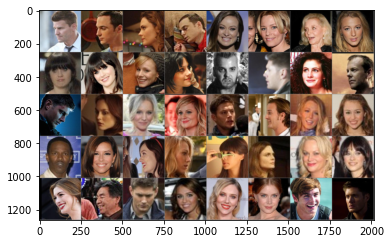

tensor([ 6, 27, 14, 27, 24,  9, 17, 18, 15, 15, 12, 21,  3, 10,  1,  3, 10, 23,
        12, 20, 10, 10, 18, 26,  7, 19, 23, 18, 15, 14, 20, 15,  5,  2, 10, 26,
        17, 11, 25, 10])
torch.Size([3, 250, 250])


In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(labels)
print(images[1].shape)

2.Implementacja BatchNormalization2d wg wykładu.

In [ ]:
class MyBatchNorm2d(nn.Module):
  def __init__(self, channelNum, eps = 1e-5, momentum=0.1):
    super(MyBatchNorm2d, self).__init__()
    self.channelNum = channelNum
    self.eps = eps
    self.momentum = momentum
    device = torch.device('cuda')
    self.gammas = torch.ones(channelNum, requires_grad=True, device=device)
    self.betas = torch.zeros(channelNum, requires_grad=True, device=device)

  def forward(self, x):
    assert(len(x.shape) == 4)
    channels = x.shape[1]
    assert(self.channelNum == channels)
    batches = []

    for i in range(channels):
      batch = x.select(1, i)
      avg = batch.mean()
      avgNormalized = batch - avg
      stddev = (avgNormalized * avgNormalized).mean()
      stddevNormalized = avgNormalized / torch.sqrt(stddev + self.eps)
      normalized_batch = stddevNormalized * self.gammas[i] + self.betas[i]
      batches.append(normalized_batch)

    result = torch.stack(batches, 1)
    return result

Opis architektury: Do eksperymentów użyłem modelu składającego się z 4 warstw konwolucyjnych oraz dwóch gęstych. Liczbę kanałów starałem się zwiększać wraz z kolejnymi warstwami tak, jak to było robione w architekturach zaprezentowanych na wykładzie (kolejne wielkości to 20, 40, 80, 160). W pierwszej warstwie maxPool wyciąga maksimum z kwadratów 3x3, a w następnych z 2x2. Wszędzie funkjcą aktywacji jest relu. Ponadto, między warstwami konwolucyjnymi znajduje się zaimplementowana wyżej warstwa MyBatchNorm2d, zaś między warstwami gęstymi znajduje się warstwa jednowymiarowej normalizacji (normalizację można wyłączyć ustawiając normalize=False w konstruktorze modelu). Próbowałem też używać dropoutu, ale niezależnie od dobieranych prawdopodobieństw skuteczność na zbiorze walidacyjnym spadała, więc ostatecznie go odpuściłem. Wielkości kerneli starałem się dobierać eksperymentalnie (dla kolejnych warstw rozmiary kerneli to 5, 3, 3, 2). Pośrednia warstwa gęsta składa się z 500 nodów. Funkjcją kosztu jest CrossEntropyLoss 

In [ ]:
class Net(nn.Module):
  def __init__(self, normalize=True):
    super(Net, self).__init__()
    self.normalize = normalize

    self.pool = nn.MaxPool2d(3)
    self.pool2 = nn.MaxPool2d(2)
    # self.dropout1 = nn.Dropout2d(0.25)
    # self.dropout2 = nn.Dropout(0.45)
    self.conv1 = nn.Conv2d(3, 20, 5)
    self.batchNorm1 = MyBatchNorm2d(20)
    self.conv2 = nn.Conv2d(20, 40, 3)
    self.batchNorm2 = MyBatchNorm2d(40)
    self.conv3 = nn.Conv2d(40, 80, 3)
    self.batchNorm3 = MyBatchNorm2d(80)
    self.conv4 = nn.Conv2d(80, 160, 2)
    self.batchNorm4 = MyBatchNorm2d(160)
    self.fc1 = nn.Linear(160 * 9 * 9, 500)
    self.batchNorm5 = nn.BatchNorm1d(500)
    self.fc2 = nn.Linear(500, 28)

  def forward(self, x):

    # Pierwsza warstwa konwolucyjna - 20 kanałów, kernel 5x5, max pool 3x3
    x = self.conv1(x)
    if (self.normalize):
      x = self.batchNorm1(x)
    x = F.relu(x)
    x = self.pool(x)
    # x = self.dropout1(x)
    
    # Druga warstwa konwolucyjna - 40 kanałów, kernel 3x3, max pool 2x2
    x = self.conv2(x)
    if (self.normalize):
      x = self.batchNorm2(x)
    x = F.relu(x)
    x = self.pool2(x)
    # x = self.dropout1(x)

    # Trzecia warstwa konwolucyjna - 80 kanałów, kernel 3x3, max pool 2x2
    x = self.conv3(x)
    if (self.normalize):
      x = self.batchNorm3(x)
    x = F.relu(x)
    x = self.pool2(x)
    # x = self.dropout1(x)
    
    # Czwarta warstwa konwolucyjna - 160 kanałów, kernel 2x2, max pool 2x2
    x = self.conv4(x)
    if (self.normalize):
      x = self.batchNorm4(x)
    x = F.relu(x)
    x = self.pool2(x)
    # x = self.dropout1(x)

    # Pierwsza warstwa gęsta - 500 nodów
    x = x.view(-1, 160 * 9 * 9)
    x = self.fc1(x)
    if (self.normalize):
      x = self.batchNorm5(x)
    x = F.relu(x)
    # x = self.dropout2(x)        

    # Ostatnia warstwa - 28 nodów (tyle ile klas)
    x = self.fc2(x)
    return x

criterion = nn.CrossEntropyLoss()

3. Eksperymenty

Eksperymenty trwały po 8 epok (bo po około 6-7 epokach progress w treningach ustawał). Skuteczność na zbiorze walidacyjnym była mierzona 2 razy w ciągu epoki, loss na zbiorze treningowym był liczony po każdych 500 przetrenowanych obrazkach (kod jest zrobiony tak, żeby wszystko się skalowało przy różnych batch_sizach). Dostępne są opcje wyłączenia normalizacji, włączenia wypisywania lossa na zbiorze walidacyjnym oraz włączenia ewaluacji na zbiorze testowym (razem z rysowaniem macierzy do punktu 4.). Wartości parametrów, na podstawie których dobierałem model to: 

-optimizer=Adam
-batch_size=40
-normalize=True

więc to było punktem startowym do dalszych eksperymentów

In [ ]:
def perform_experiment(optimizer, batch_size, num_epochs=8, normalize=True, print_valid_loss=False, do_test=False):
  trainloader, validloader, testloader = get_data(batch_size=batch_size)
  net = Net(normalize = normalize)
  net.cuda()
  optimizer = optimizer(net.parameters())
  # use below line for SGD
  # optimizer = optimizer(net.parameters(), lr=0.01, momentum=0.9)
  losses = []
  valid_losses = []
  scores = []
  for epoch in range(num_epochs):
      print('Epoch: ' , epoch + 1)
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          inputs, labels = data
          inputs = inputs.cuda()
          labels = labels.cuda()

          optimizer.zero_grad()

          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          if (i * batch_size % 500 < batch_size and i > 0): 
              loss_per_batch = running_loss * batch_size / 500
              losses.append(loss_per_batch)
              print('step %d loss: %.3f' %
                    (i * batch_size, loss_per_batch))
              running_loss = 0.0

          if (i * batch_size % 4500 < batch_size and i > 0) :
            # net.eval()
            correct = 0
            total = 0
            valid_loss = 0
            with torch.no_grad():
                for data in validloader:
                    images, labels = data
                    images = images.cuda()
                    labels = labels.cuda()
                    outputs = net(images)

                    if (print_valid_loss):
                      loss = criterion(outputs, labels)
                      valid_loss += loss.item()

                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                accuracy = 100 * correct / total
                scores.append(accuracy)

            print('Accuracy on validation set: %.2f %%' % (
                100 * correct / total))
            
            if (print_valid_loss):
              valid_loss_per_batch = valid_loss * batch_size / 2000
              valid_losses.append(valid_loss_per_batch)
              print('Loss on validation set: %.3f' %
                    (valid_loss_per_batch))
            
            # net.train()
    
  if (do_test):
    confusion_matrix = np.zeros((28, 28))
    correct = 0
    total = 0
    with torch.no_grad():
      for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        _,predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range (len(predicted)):
          a = predicted[i]
          b = labels[i]
          confusion_matrix[a, b] += 1

    print('Accuracy on test set: %.2f %%' % (
                100 * correct / total))
    
    df_cm = pd.DataFrame(confusion_matrix, range(28), range(28))
    plt.figure(figsize=(50,50))
    sn.set(font_scale=1.4) 
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) 


  return scores, losses, valid_losses

3.1 Zależność między lossem na zbiorze treningowym, a lossem na zbiorze walidacyjnym: Jak widać, z początku oba lossy maleją w podobnym tempie. Jednak po 1-2 epokach loss na zbiorze walidacyjnym zaczyna spadać wolniej, niż na zbiorze treningowym (sieć się overfittuje). Pod koniec treningu loss na zbiorze treningowym jest prawie zerowy, a na zbiorze walidacyjnym oscyluje w granicach 0.7-0.8

In [ ]:
_, train_losses, valid_losses = perform_experiment(optimizer=optim.Adam, batch_size=40, print_valid_loss=True)

Epoch:  1
step 520 loss: 3.443
step 1000 loss: 2.461
step 1520 loss: 2.433
step 2000 loss: 2.006
step 2520 loss: 2.024
step 3000 loss: 1.778
step 3520 loss: 1.819
step 4000 loss: 1.629
step 4520 loss: 1.548
Accuracy on validation set: 56.60 %
Loss on validation set: 1.538
step 5000 loss: 1.390
step 5520 loss: 1.298
step 6000 loss: 1.467
step 6520 loss: 1.375
step 7000 loss: 1.259
step 7520 loss: 1.225
step 8000 loss: 1.035
step 8520 loss: 1.301
step 9000 loss: 1.149
Accuracy on validation set: 69.75 %
Loss on validation set: 1.114
Epoch:  2
step 520 loss: 0.832
step 1000 loss: 0.665
step 1520 loss: 0.649
step 2000 loss: 0.599
step 2520 loss: 0.694
step 3000 loss: 0.580
step 3520 loss: 0.656
step 4000 loss: 0.680
step 4520 loss: 0.668
Accuracy on validation set: 72.90 %
Loss on validation set: 0.960
step 5000 loss: 0.626
step 5520 loss: 0.639
step 6000 loss: 0.621
step 6520 loss: 0.605
step 7000 loss: 0.666
step 7520 loss: 0.776
step 8000 loss: 0.676
step 8520 loss: 0.688
step 9000 loss

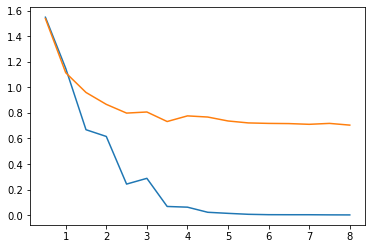

In [ ]:
sub_train_losses = []
i = 8
while i < len(train_losses):
  sub_train_losses.append(train_losses[i])
  i = i + 9
  
epochs = [0.5 * i for i in range (1, len(sub_train_losses) + 1)]

plt.plot(epochs, sub_train_losses,
         epochs, valid_losses)

3.2 Porówanie skuteczności z BatchNorm i bez: Widzimy, że bez normalizacji model uczy się wolniej i o wiele słabiej (z normalizacją model osiąga rezutlaty w granicach 80-85%, bez normalizacji ledwie koło 65%)

In [ ]:
adam_unnormalized = perform_experiment(optimizer=optim.Adam, normalize=False, batch_size=40) 

Epoch:  1
step 520 loss: 3.727
step 1000 loss: 3.177
step 1520 loss: 3.338
step 2000 loss: 3.047
step 2520 loss: 3.178
step 3000 loss: 2.761
step 3520 loss: 2.971
step 4000 loss: 2.611
step 4520 loss: 2.637
Accuracy on validation set: 28.15 %
step 5000 loss: 2.366
step 5520 loss: 2.445
step 6000 loss: 2.128
step 6520 loss: 2.344
step 7000 loss: 2.149
step 7520 loss: 2.202
step 8000 loss: 1.973
step 8520 loss: 2.063
step 9000 loss: 1.928
Accuracy on validation set: 42.85 %
Epoch:  2
step 520 loss: 1.934
step 1000 loss: 1.715
step 1520 loss: 1.687
step 2000 loss: 1.640
step 2520 loss: 1.785
step 3000 loss: 1.616
step 3520 loss: 1.741
step 4000 loss: 1.591
step 4520 loss: 1.508
Accuracy on validation set: 52.75 %
step 5000 loss: 1.403
step 5520 loss: 1.615
step 6000 loss: 1.524
step 6520 loss: 1.407
step 7000 loss: 1.357
step 7520 loss: 1.408
step 8000 loss: 1.307
step 8520 loss: 1.333
step 9000 loss: 1.194
Accuracy on validation set: 57.60 %
Epoch:  3
step 520 loss: 1.099
step 1000 loss:

In [ ]:
adam_normalized = perform_experiment(optimizer=optim.Adam, batch_size=40) 

Epoch:  1
step 520 loss: 3.493
step 1000 loss: 2.447
step 1520 loss: 2.441
step 2000 loss: 2.096
step 2520 loss: 2.117
step 3000 loss: 1.801
step 3520 loss: 1.757
step 4000 loss: 1.551
step 4520 loss: 1.683
Accuracy on validation set: 57.45 %
step 5000 loss: 1.439
step 5520 loss: 1.544
step 6000 loss: 1.294
step 6520 loss: 1.381
step 7000 loss: 1.211
step 7520 loss: 1.270
step 8000 loss: 1.143
step 8520 loss: 1.384
step 9000 loss: 1.087
Accuracy on validation set: 69.55 %
Epoch:  2
step 520 loss: 0.884
step 1000 loss: 0.644
step 1520 loss: 0.798
step 2000 loss: 0.626
step 2520 loss: 0.684
step 3000 loss: 0.682
step 3520 loss: 0.730
step 4000 loss: 0.613
step 4520 loss: 0.700
Accuracy on validation set: 75.25 %
step 5000 loss: 0.751
step 5520 loss: 0.621
step 6000 loss: 0.673
step 6520 loss: 0.705
step 7000 loss: 0.740
step 7520 loss: 0.658
step 8000 loss: 0.571
step 8520 loss: 0.764
step 9000 loss: 0.602
Accuracy on validation set: 75.95 %
Epoch:  3
step 520 loss: 0.352
step 1000 loss:

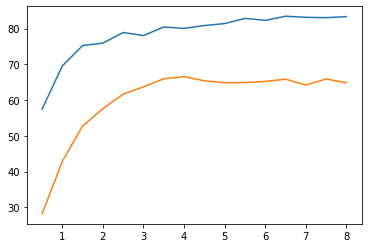

In [ ]:
adam_normalized_accuracy, _, _ = adam_normalized
adam_unnormalized_accuracy, _, _ = adam_unnormalized

plt.plot(epochs, adam_normalized_accuracy,
         epochs, adam_unnormalized_accuracy)

3.3 Porównanie optimizerów
Adam zosatł użyty już wyżej. Porónamy go z optimizerami poznanymi na wykładzie (tzn zwykłym SGD z momentum 0.9, Adagradem i RMSPropem).

In [ ]:
adagrad= perform_experiment(optimizer=optim.Adagrad, batch_size=40) 

Epoch:  1
step 520 loss: 3.959
step 1000 loss: 2.712
step 1520 loss: 2.625
step 2000 loss: 2.305
step 2520 loss: 2.198
step 3000 loss: 1.944
step 3520 loss: 2.095
step 4000 loss: 1.740
step 4520 loss: 1.903
Accuracy on validation set: 49.60 %
step 5000 loss: 1.605
step 5520 loss: 1.767
step 6000 loss: 1.543
step 6520 loss: 1.624
step 7000 loss: 1.334
step 7520 loss: 1.320
step 8000 loss: 1.316
step 8520 loss: 1.375
step 9000 loss: 1.213
Accuracy on validation set: 64.30 %
Epoch:  2
step 520 loss: 1.051
step 1000 loss: 0.869
step 1520 loss: 0.837
step 2000 loss: 0.765
step 2520 loss: 0.963
step 3000 loss: 0.794
step 3520 loss: 0.775
step 4000 loss: 0.775
step 4520 loss: 0.925
Accuracy on validation set: 72.40 %
step 5000 loss: 0.754
step 5520 loss: 0.792
step 6000 loss: 0.727
step 6520 loss: 0.754
step 7000 loss: 0.754
step 7520 loss: 0.778
step 8000 loss: 0.716
step 8520 loss: 0.835
step 9000 loss: 0.591
Accuracy on validation set: 74.55 %
Epoch:  3
step 520 loss: 0.423
step 1000 loss:

In [ ]:
rmsprop = perform_experiment(optimizer=optim.RMSprop, batch_size=40) 

Epoch:  1
step 520 loss: 9.140
step 1000 loss: 3.471
step 1520 loss: 3.218
step 2000 loss: 2.855
step 2520 loss: 2.902
step 3000 loss: 2.562
step 3520 loss: 2.610
step 4000 loss: 2.417
step 4520 loss: 2.439
Accuracy on validation set: 31.70 %
step 5000 loss: 2.288
step 5520 loss: 2.416
step 6000 loss: 2.148
step 6520 loss: 2.205
step 7000 loss: 1.928
step 7520 loss: 1.949
step 8000 loss: 1.838
step 8520 loss: 1.884
step 9000 loss: 1.601
Accuracy on validation set: 49.20 %
Epoch:  2
step 520 loss: 1.619
step 1000 loss: 1.392
step 1520 loss: 1.444
step 2000 loss: 1.294
step 2520 loss: 1.513
step 3000 loss: 1.403
step 3520 loss: 1.459
step 4000 loss: 1.203
step 4520 loss: 1.328
Accuracy on validation set: 58.35 %
step 5000 loss: 1.161
step 5520 loss: 1.274
step 6000 loss: 1.161
step 6520 loss: 1.317
step 7000 loss: 1.170
step 7520 loss: 1.384
step 8000 loss: 1.205
step 8520 loss: 1.155
step 9000 loss: 1.105
Accuracy on validation set: 62.25 %
Epoch:  3
step 520 loss: 0.759
step 1000 loss:

Jako, ze zapomniałem w funkcji perform_experiment o przekazywaniu argumentów do optimizera, to aby odpalić poniższą linię musiałem tymczasowo w ciele tej funkcji zmienić linię

optimizer = optimizer(net.parameters())

na 

optimizer = optimizer(net.parameters(), lr=0.01, momentum=0.9)

In [ ]:
sgd = perform_experiment(optimizer=optim.SGD, batch_size=40) 

Epoch:  1
step 520 loss: 3.521
step 1000 loss: 2.569
step 1520 loss: 2.510
step 2000 loss: 2.115
step 2520 loss: 2.281
step 3000 loss: 1.873
step 3520 loss: 1.957
step 4000 loss: 1.560
step 4520 loss: 1.738
Accuracy on validation set: 54.10 %
step 5000 loss: 1.502
step 5520 loss: 1.514
step 6000 loss: 1.347
step 6520 loss: 1.393
step 7000 loss: 1.301
step 7520 loss: 1.220
step 8000 loss: 1.314
step 8520 loss: 1.249
step 9000 loss: 1.182
Accuracy on validation set: 66.00 %
Epoch:  2
step 520 loss: 0.916
step 1000 loss: 0.816
step 1520 loss: 0.793
step 2000 loss: 0.706
step 2520 loss: 0.789
step 3000 loss: 0.732
step 3520 loss: 0.718
step 4000 loss: 0.673
step 4520 loss: 0.863
Accuracy on validation set: 71.55 %
step 5000 loss: 0.615
step 5520 loss: 0.713
step 6000 loss: 0.581
step 6520 loss: 0.778
step 7000 loss: 0.688
step 7520 loss: 0.848
step 8000 loss: 0.717
step 8520 loss: 0.668
step 9000 loss: 0.613
Accuracy on validation set: 74.55 %
Epoch:  3
step 520 loss: 0.377
step 1000 loss:

Jak widać, adam spisuje się trochę lepiej (różnica 2-3%) od adagradu i sgd z momentum=0.9 (które zachowują się niemal identycznie). Z kolei rmsprop wypada bardzo słabo w porównaniu do reszty optimizerów.

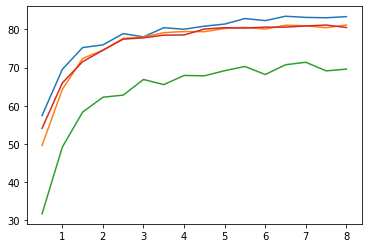

In [ ]:
sgd_accuracy,_,_ = sgd
rmsrpop_accuracy,_,_ = rmsprop
adagrad_accuracy,_,_ = adagrad

plt.plot(epochs, adam_normalized_accuracy,
         epochs, adagrad_accuracy,
         epochs, rmsprop_accuracy,
         epochs, sgd_accuracy)


3.4 Eksperymenty z wielkością batcha
Jako, że Adam wypadł najlepiej, był on użwany jako optimizer w dalszych eksperymentach. Wypróbowałem batch_size = 10,40,100,500. Batch size 40 już był używany wyżej, więc niżej przeprowadziłem eksperymenty dla pozostałych wielkości

In [ ]:
batch_100 = perform_experiment(optimizer=optim.Adam, batch_size=100) 

Epoch:  1
step 500 loss: 3.763
step 1000 loss: 2.622
step 1500 loss: 2.407
step 2000 loss: 2.230
step 2500 loss: 2.033
step 3000 loss: 1.964
step 3500 loss: 1.831
step 4000 loss: 1.688
step 4500 loss: 1.671
Accuracy on validation set: 56.80 %
step 5000 loss: 1.661
step 5500 loss: 1.510
step 6000 loss: 1.397
step 6500 loss: 1.259
step 7000 loss: 1.243
step 7500 loss: 1.256
step 8000 loss: 1.154
step 8500 loss: 1.210
step 9000 loss: 1.119
Accuracy on validation set: 68.75 %
Epoch:  2
step 500 loss: 1.010
step 1000 loss: 0.759
step 1500 loss: 0.686
step 2000 loss: 0.779
step 2500 loss: 0.641
step 3000 loss: 0.593
step 3500 loss: 0.664
step 4000 loss: 0.643
step 4500 loss: 0.611
Accuracy on validation set: 75.95 %
step 5000 loss: 0.596
step 5500 loss: 0.632
step 6000 loss: 0.596
step 6500 loss: 0.659
step 7000 loss: 0.660
step 7500 loss: 0.613
step 8000 loss: 0.672
step 8500 loss: 0.557
step 9000 loss: 0.618
Accuracy on validation set: 76.65 %
Epoch:  3
step 500 loss: 0.372
step 1000 loss:

In [ ]:
batch_10 = perform_experiment(optimizer=optim.Adam, batch_size=10) 

Epoch:  1
step 500 loss: 3.204
step 1000 loss: 2.761
step 1500 loss: 2.583
step 2000 loss: 2.276
step 2500 loss: 2.115
step 3000 loss: 2.102
step 3500 loss: 2.023
step 4000 loss: 1.802
step 4500 loss: 1.733
Accuracy on validation set: 53.15 %
step 5000 loss: 1.641
step 5500 loss: 1.622
step 6000 loss: 1.632
step 6500 loss: 1.380
step 7000 loss: 1.430
step 7500 loss: 1.460
step 8000 loss: 1.318
step 8500 loss: 1.333
step 9000 loss: 1.217
Accuracy on validation set: 65.30 %
Epoch:  2
step 500 loss: 0.923
step 1000 loss: 0.820
step 1500 loss: 0.899
step 2000 loss: 0.983
step 2500 loss: 0.951
step 3000 loss: 0.922
step 3500 loss: 0.821
step 4000 loss: 0.884
step 4500 loss: 1.019
Accuracy on validation set: 69.25 %
step 5000 loss: 0.880
step 5500 loss: 0.894
step 6000 loss: 0.909
step 6500 loss: 0.998
step 7000 loss: 0.844
step 7500 loss: 0.808
step 8000 loss: 0.822
step 8500 loss: 0.967
step 9000 loss: 0.783
Accuracy on validation set: 72.10 %
Epoch:  3
step 500 loss: 0.525
step 1000 loss:

In [ ]:
batch_500 = perform_experiment(optimizer=optim.Adam, batch_size=500) 

Epoch:  1
step 500 loss: 6.341
step 1000 loss: 2.811
step 1500 loss: 2.487
step 2000 loss: 2.385
step 2500 loss: 2.327
step 3000 loss: 2.236
step 3500 loss: 2.100
step 4000 loss: 2.009
step 4500 loss: 1.839
Accuracy on validation set: 50.50 %
step 5000 loss: 1.833
step 5500 loss: 1.880
step 6000 loss: 1.630
step 6500 loss: 1.712
step 7000 loss: 1.619
step 7500 loss: 1.600
step 8000 loss: 1.623
step 8500 loss: 1.554
step 9000 loss: 1.536
Accuracy on validation set: 61.70 %
Epoch:  2
step 500 loss: 2.278
step 1000 loss: 1.109
step 1500 loss: 1.047
step 2000 loss: 1.135
step 2500 loss: 1.036
step 3000 loss: 1.042
step 3500 loss: 0.967
step 4000 loss: 1.011
step 4500 loss: 0.934
Accuracy on validation set: 69.85 %
step 5000 loss: 0.960
step 5500 loss: 0.877
step 6000 loss: 0.783
step 6500 loss: 0.822
step 7000 loss: 0.814
step 7500 loss: 0.845
step 8000 loss: 0.789
step 8500 loss: 0.811
step 9000 loss: 0.682
Accuracy on validation set: 72.75 %
Epoch:  3
step 500 loss: 1.004
step 1000 loss:

In [ ]:
batch_500_accuracy,_,_ = batch_500
batch_10_accuracy,_,_ = batch_10
batch_100_accuracy,_,_ = batch_100

Najlepsze wyniki dają batche wielkości 40 i 100 (koło 83%). Batch wielkości 500 jest już za duży i daje wyniki koło 80%, batch wielkości 10 jest zdecydowanie za mały i daje wyniki rzędu 75%.

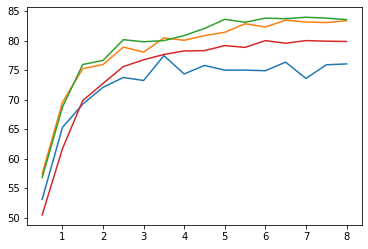

In [ ]:
plt.plot(epochs, batch_10_accuracy,
         epochs, adam_normalized_accuracy, #batch_size 40
         epochs, batch_100_accuracy,
         epochs, batch_500_accuracy)

4. Wyniki
Okazuje się więc, że początkowy wybór batch_size=40 i optimizer=Adam był optymalny (ale może to też po części wynikać z tego, że na podstwie tych parametrów dobierałem potem parametry sieci konwolucyjnej).

Model osiąga na zbiorze testowym wynik ~82%. Poniżej narysowana jest też macierz pomyłek (confusion matrix). Kolumny odpowiadają poprawnym etykietom klas, zaś wiersze etykietom wskazanym przez klasyfikator (tzn, wartość w i-tym wierszu i j-tej kolumnie odpowiada przypadkom, w których klasyfikator wskazał i-tą klasę zamiast j-tej).

Epoch:  1
step 520 loss: 3.488
step 1000 loss: 2.543
step 1520 loss: 2.544
step 2000 loss: 2.083
step 2520 loss: 2.112
step 3000 loss: 1.801
step 3520 loss: 1.862
step 4000 loss: 1.539
step 4520 loss: 1.636
Accuracy on validation set: 53.05 %
step 5000 loss: 1.567
step 5520 loss: 1.360
step 6000 loss: 1.225
step 6520 loss: 1.503
step 7000 loss: 1.141
step 7520 loss: 1.311
step 8000 loss: 1.081
step 8520 loss: 1.325
step 9000 loss: 1.093
Accuracy on validation set: 67.55 %
Epoch:  2
step 520 loss: 0.900
step 1000 loss: 0.773
step 1520 loss: 0.734
step 2000 loss: 0.634
step 2520 loss: 0.716
step 3000 loss: 0.666
step 3520 loss: 0.720
step 4000 loss: 0.584
step 4520 loss: 0.731
Accuracy on validation set: 71.80 %
step 5000 loss: 0.611
step 5520 loss: 0.746
step 6000 loss: 0.669
step 6520 loss: 0.687
step 7000 loss: 0.639
step 7520 loss: 0.726
step 8000 loss: 0.716
step 8520 loss: 0.779
step 9000 loss: 0.635
Accuracy on validation set: 76.70 %
Epoch:  3
step 520 loss: 0.331
step 1000 loss:

([53.05,
  67.55,
  71.8,
  76.7,
  76.95,
  77.55,
  79.45,
  78.45,
  80.35,
  80.3,
  81.6,
  81.5,
  80.8,
  81.65,
  81.95,
  82.05],
 [3.4875671577453615,
  2.542681255340576,
  2.543940601348877,
  2.0826834201812745,
  2.1119283771514894,
  1.8006216621398925,
  1.8617692470550538,
  1.5388678741455077,
  1.6357362461090088,
  1.5670064067840577,
  1.3602570915222167,
  1.225332064628601,
  1.5026774311065674,
  1.1407987213134765,
  1.311396026611328,
  1.0805914068222047,
  1.3252747631072999,
  1.0931811475753783,
  0.9002765417098999,
  0.7729679107666015,
  0.733717839717865,
  0.6344031143188477,
  0.7156063675880432,
  0.6661978530883789,
  0.7197675108909607,
  0.583842248916626,
  0.7306072807312012,
  0.6105306720733643,
  0.7460640287399292,
  0.6688288307189941,
  0.6866288900375366,
  0.6394109988212585,
  0.7263207221031189,
  0.716035475730896,
  0.7794336652755738,
  0.6352355718612671,
  0.3306343114376068,
  0.2438807952404022,
  0.31157209396362306,
  0.27262

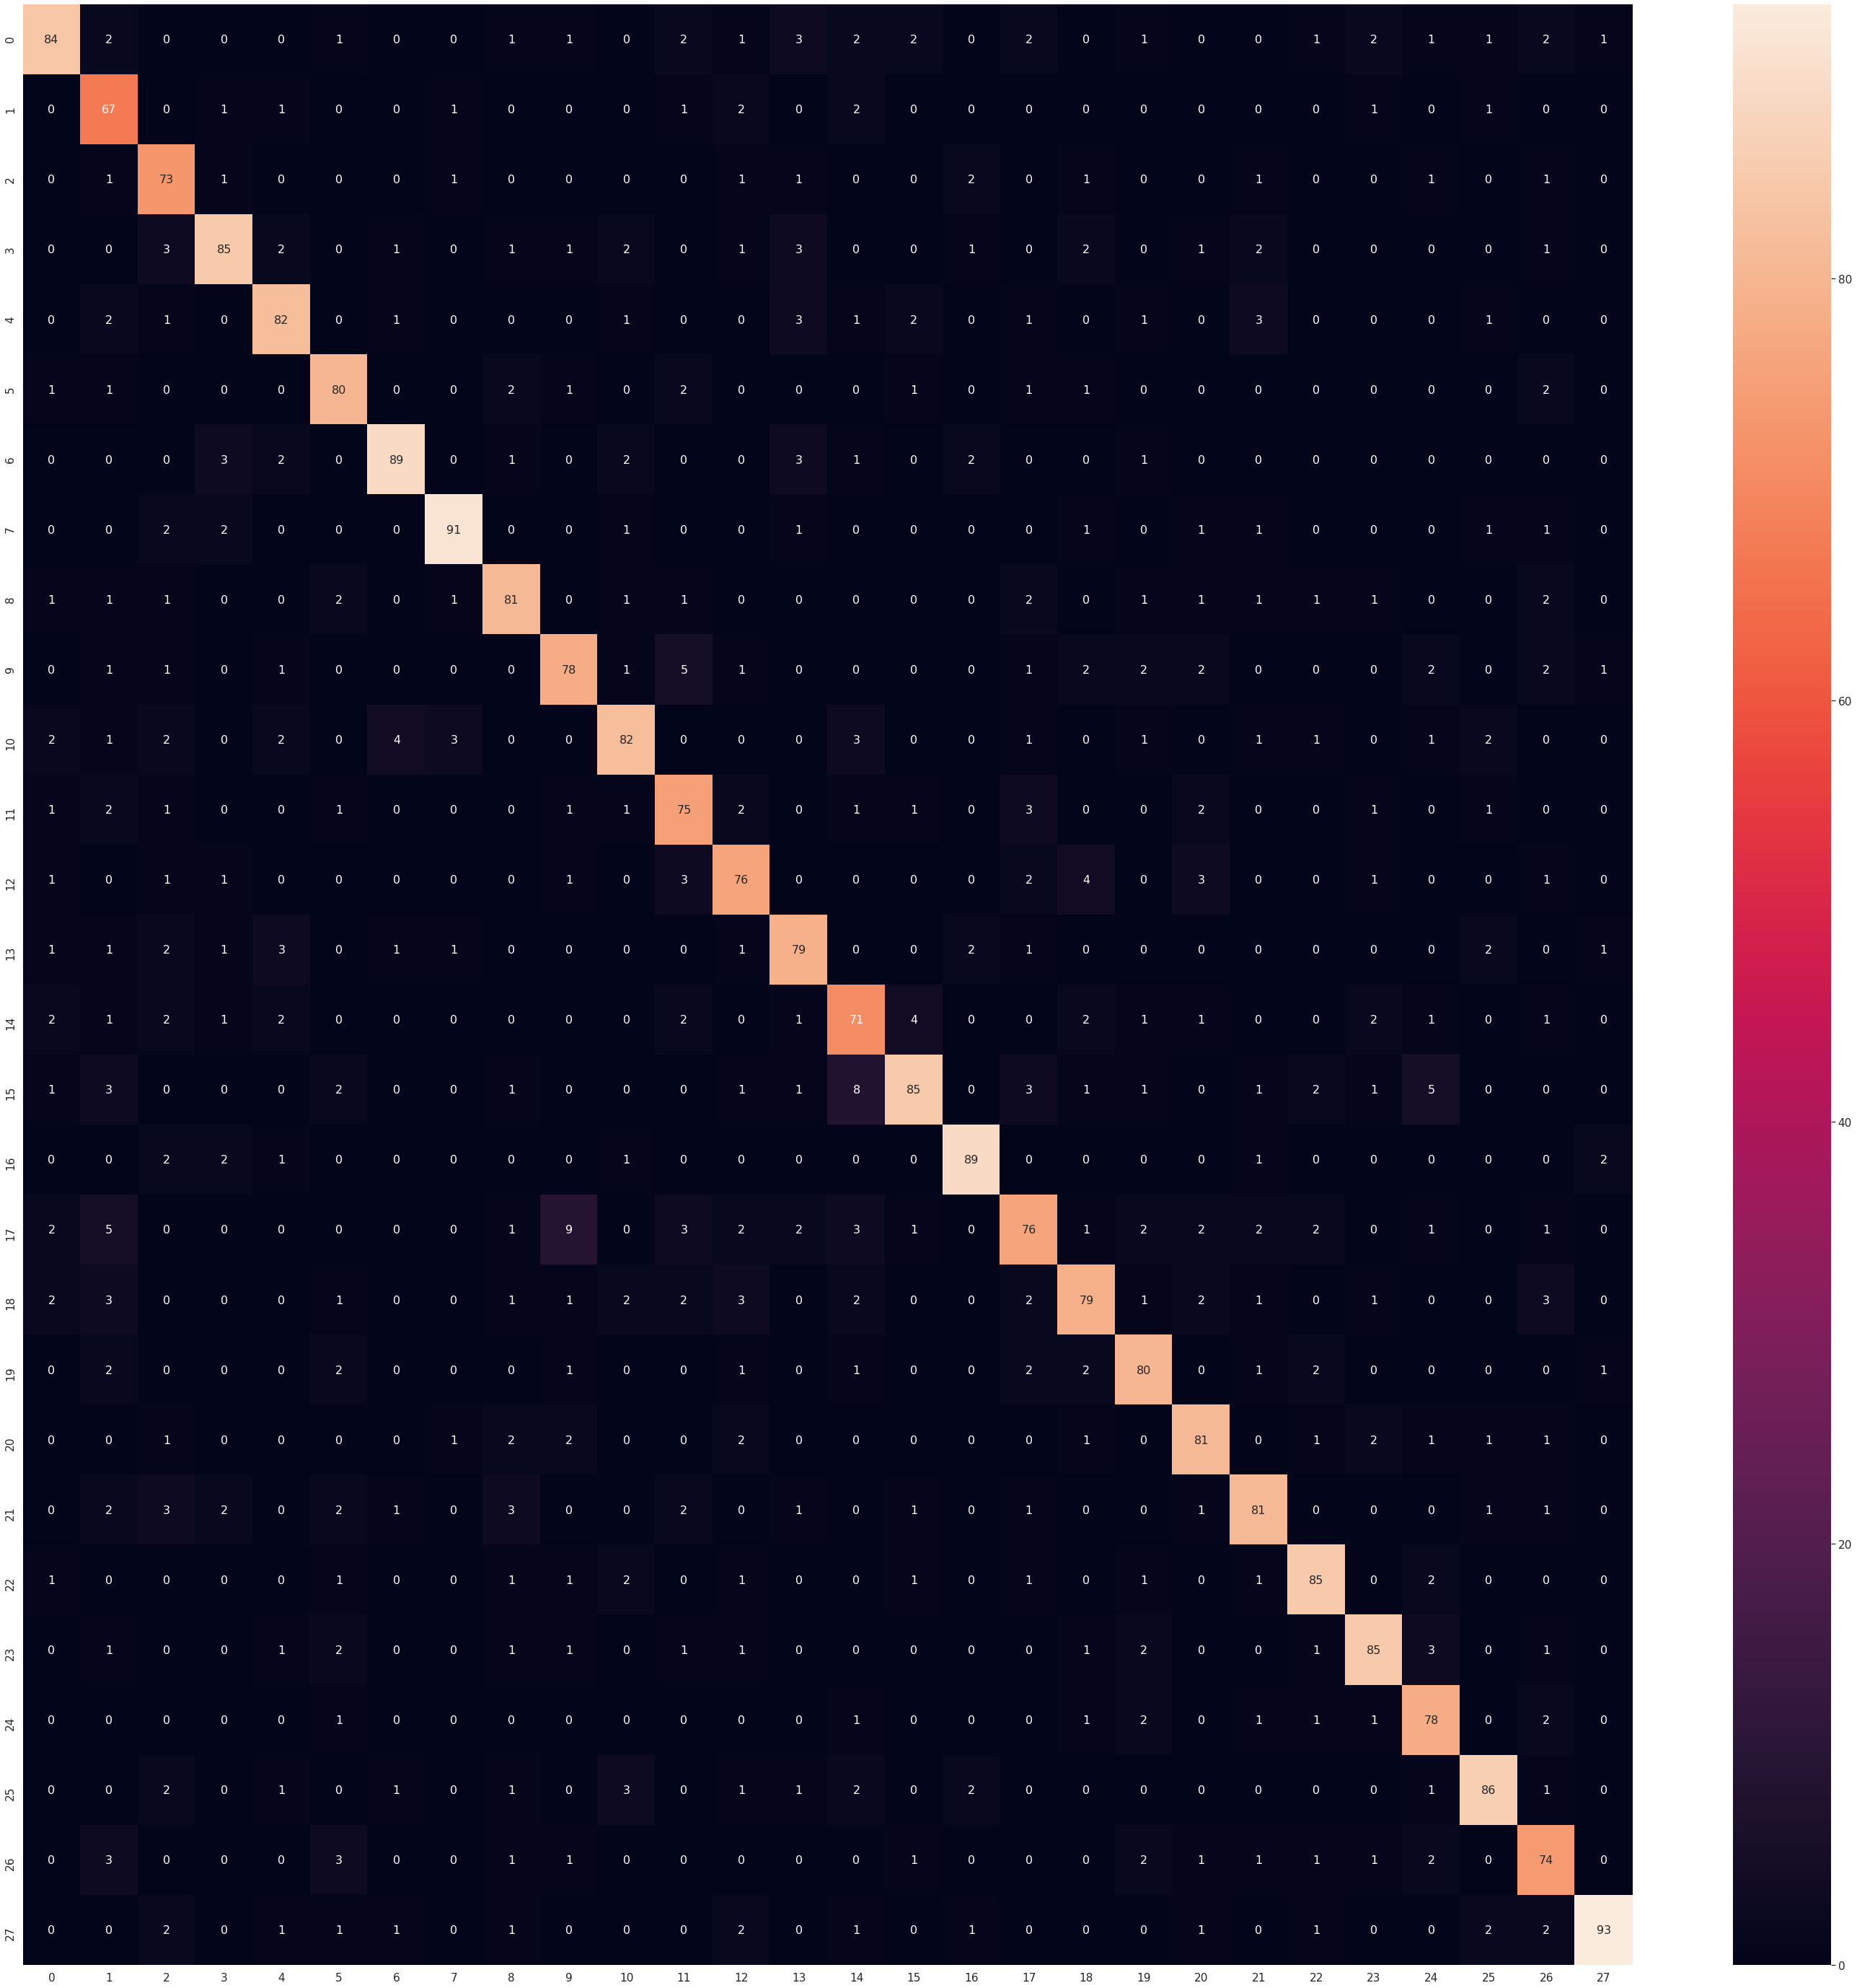

In [ ]:
perform_experiment(optimizer=optim.Adam, batch_size=40, do_test=True) 

Jak widać, klasyfikator najczęściej mylił klasy 14 i 15. Po zajrzeniu do zbioru testowego okazuje się, że istotnie obie panie wyglądają dość podobnie:

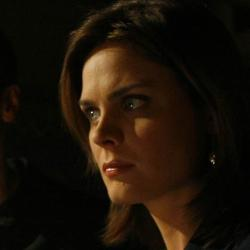

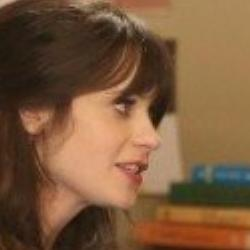

In [ ]:
display(Image('dnn2020-1/test/0221043/011.jpg'))
display(Image('dnn2020-1/test/0221046/003.jpg'))

Model zgadywał też często, że zdjącie należy do klasy 17, zamiast do klasy 9, co zapewne wynika z podobnego koloru włosów u obu pań na kilku zdjęciach.

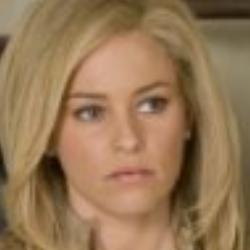

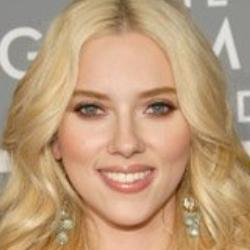

In [ ]:
display(Image('dnn2020-1/test/0006969/074.jpg'))
display(Image('dnn2020-1/test/0424060/066.jpg'))

Jeżeli zaś chodzi o klasę, którą klasyfikator najczęściej (sumarycznie) mylił z innymi klasamy, to jest to klasa numer 1. Myślę, ze może to wynikać z faktu, że w ziorze testowym dla tej klasy jest wyjątkowo dużo rozmazanych i biało-czarnych zdjęć (i ogółem zdjęć słabej jakości) oraz trochę z tego, że ta pani wygląda dość podobnie do kilku innych aktorek + jej wygląd zmienia się mocno na różnych zdjęciach.

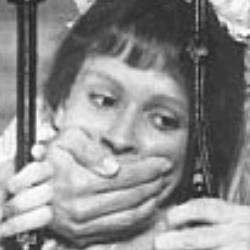

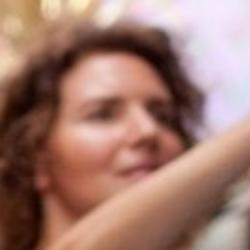

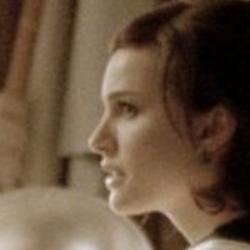

In [ ]:
display(Image('dnn2020-1/test/0000210/068.jpg'))
display(Image('dnn2020-1/test/0000210/007.jpg'))
display(Image('dnn2020-1/test/0000210/025.jpg'))

Najskuteczniejszy był zaś dla pana z ostatniej klasy. Ma to sens, bo w na wszyskich zdjęciach ma on dość podobną fryzurę i nie zmienia drastyczny wyglądu przy wcielaniu się w różne role.

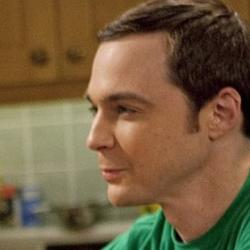

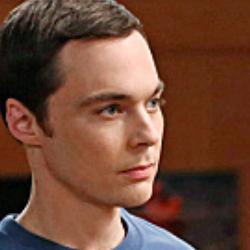

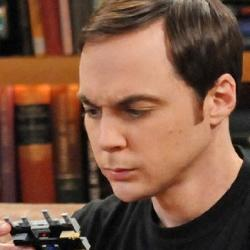

In [ ]:
display(Image('dnn2020-1/test/1433588/023.jpg'))
display(Image('dnn2020-1/test/1433588/024.jpg'))
display(Image('dnn2020-1/test/1433588/025.jpg'))

Ogółem klasyfikator działa dość sensownie. Z reguły myli osoby w obrębie jednej płci, a nie kobiety z mężczyznami i lepiej rozróżnia mężczyzn (bo mniej zmieniają oni swój wygląd). Jak widać też wyżej, pomyłki są często uzasadnione tym, że dwie osoby z różnych klas wyglądają podobnie.